In [2]:
import pandas as pd
import numpy as np
import warnings

# Scikit-learn imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_score, recall_score, f1_score, roc_auc_score, roc_curve
)

# Imbalanced-learn imports
try:
    from imblearn.over_sampling import SMOTE, ADASYN
    IMBALANCE_AVAILABLE = True
    print("✓ imbalanced-learn imported successfully")
except ImportError:
    print("⚠ Warning: imbalanced-learn not found. Install with: pip install imbalanced-learn")
    IMBALANCE_AVAILABLE = False

# XGBoost import
try:
    from xgboost import XGBClassifier
    XGBOOST_AVAILABLE = True
    print("✓ XGBoost imported successfully")
except ImportError:
    print("⚠ Warning: XGBoost not found. Install with: pip install xgboost")
    XGBOOST_AVAILABLE = False

# Visualization imports
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
sns.set_style('whitegrid')

print("✓ Core libraries imported successfully")


✓ imbalanced-learn imported successfully
✓ XGBoost imported successfully
✓ Core libraries imported successfully


In [6]:
 pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [8]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
CONFIG = {
    'dataset_path': 'data/NF-UNSW-NB15-v3.csv',
    'target_column': 'Label',  # Adjust based on your dataset
    'test_size': 0.3,
    'random_state': 42,
    'anomaly_detector': 'isolation_forest',  # Options: 'isolation_forest', 'lof'
    'contamination': 0.1,  # Expected proportion of anomalies
    'resampling_method': 'smote' if IMBALANCE_AVAILABLE else 'none',  # Options: 'smote', 'adasyn', 'none'
}

print("Configuration Settings:")
print("-" * 50)
for key, value in CONFIG.items():
    print(f"  {key:25s}: {value}")

if not IMBALANCE_AVAILABLE:
    print("\n⚠ Note: Resampling disabled (imbalanced-learn not installed)")

Configuration Settings:
--------------------------------------------------
  dataset_path             : data/NF-UNSW-NB15-v3.csv
  target_column            : Label
  test_size                : 0.3
  random_state             : 42
  anomaly_detector         : isolation_forest
  contamination            : 0.1
  resampling_method        : smote


LOADING DATASET
✓ Dataset loaded successfully: 2365424 rows, 55 columns

Dataset Info:
--------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2365424 entries, 0 to 2365423
Data columns (total 55 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   FLOW_START_MILLISECONDS      int64  
 1   FLOW_END_MILLISECONDS        int64  
 2   IPV4_SRC_ADDR                object 
 3   L4_SRC_PORT                  int64  
 4   IPV4_DST_ADDR                object 
 5   L4_DST_PORT                  int64  
 6   PROTOCOL                     int64  
 7   L7_PROTO                     float64
 8   IN_BYTES                     int64  
 9   IN_PKTS                      int64  
 10  OUT_BYTES                    int64  
 11  OUT_PKTS                     int64  
 12  TCP_FLAGS                    int64  
 13  CLIENT_TCP_FLAGS             int64  
 14  SERVER_TCP_FLAGS             int64  
 15  

,FLOW_START_MILLISECONDS,FLOW_END_MILLISECONDS,IPV4_SRC_ADDR,L4_SRC_PORT,IPV4_DST_ADDR,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,IN_PKTS,OUT_BYTES,OUT_PKTS,TCP_FLAGS,CLIENT_TCP_FLAGS,SERVER_TCP_FLAGS,FLOW_DURATION_MILLISECONDS,DURATION_IN,DURATION_OUT,MIN_TTL,MAX_TTL,LONGEST_FLOW_PKT,SHORTEST_FLOW_PKT,MIN_IP_PKT_LEN,MAX_IP_PKT_LEN,SRC_TO_DST_SECOND_BYTES,DST_TO_SRC_SECOND_BYTES,RETRANSMITTED_IN_BYTES,RETRANSMITTED_IN_PKTS,RETRANSMITTED_OUT_BYTES,RETRANSMITTED_OUT_PKTS,SRC_TO_DST_AVG_THROUGHPUT,DST_TO_SRC_AVG_THROUGHPUT,NUM_PKTS_UP_TO_128_BYTES,NUM_PKTS_128_TO_256_BYTES,NUM_PKTS_256_TO_512_BYTES,NUM_PKTS_512_TO_1024_BYTES,NUM_PKTS_1024_TO_1514_BYTES,TCP_WIN_MAX_IN,TCP_WIN_MAX_OUT,ICMP_TYPE,ICMP_IPV4_TYPE,DNS_QUERY_ID,DNS_QUERY_TYPE,DNS_TTL_ANSWER,FTP_COMMAND_RET_CODE,SRC_TO_DST_IAT_MIN,SRC_TO_DST_IAT_MAX,SRC_TO_DST_IAT_AVG,SRC_TO_DST_IAT_STDDEV,DST_TO_SRC_IAT_MIN,DST_TO_SRC_IAT_MAX,DST_TO_SRC_IAT_AVG,DST_TO_SRC_IAT_STDDEV,Label,Attack
0,1424242193040,1424242193043,59.166.0.2,4894,149.171.126.3,53,17,5.0,146,2,178,2,0,0,0,2,0,0,31,31,89,73,73,89,89.000000,73.000000,0,0,0,0,389333,474666,4,0,0,0,0,0,0,0,0,46779,1,60,0,0,0,0,0,0,0,0,0,0,Benign
1,1424242192744,1424242193079,59.166.0.4,52671,149.171.126.6,31992,6,11.0,4704,28,2976,28,27,27,27,335,334,334,31,32,984,52,52,984,8.883582,14.041791,1988,7,1068,6,112000,70857,34,18,2,2,0,14480,14480,50176,196,0,0,0,0,0,91,12,19,0,90,12,19,0,Benign
2,1424242190649,1424242193109,59.166.0.0,47290,149.171.126.9,6881,6,37.0,13662,238,548216,438,27,27,27,2460,2459,2459,31,32,1500,52,52,1500,222.852033,5.553659,1735,21,272908,196,44411,1782091,288,0,4,32,352,65160,34752,50944,199,0,0,0,0,0,1843,10,119,0,1843,5,88,0,Benign
3,1424242193145,1424242193146,59.166.0.8,43310,149.171.126.7,53,17,5.0,146,2,178,2,0,0,0,1,0,0,31,31,89,73,73,89,178.000000,146.000000,0,0,0,0,584000,712000,4,0,0,0,0,0,0,0,0,3211,1,60,0,0,0,0,0,0,0,0,0,0,Benign
4,1424242193239,1424242193241,59.166.0.1,45870,149.171.126.1,53,17,5.0,130,2,162,2,0,0,0,1,0,0,31,31,81,65,65,81,162.000000,130.000000,0,0,0,0,520000,648000,4,0,0,0,0,0,0,0,0,5771,1,60,0,0,0,0,0,0,0,0,0,0,Benign



Missing Values:
--------------------------------------------------------------------------------
SRC_TO_DST_SECOND_BYTES    63425
dtype: int64

Class Distribution:
--------------------------------------------------------------------------------
Label
0    2237731
1     127693
Name: count, dtype: int64


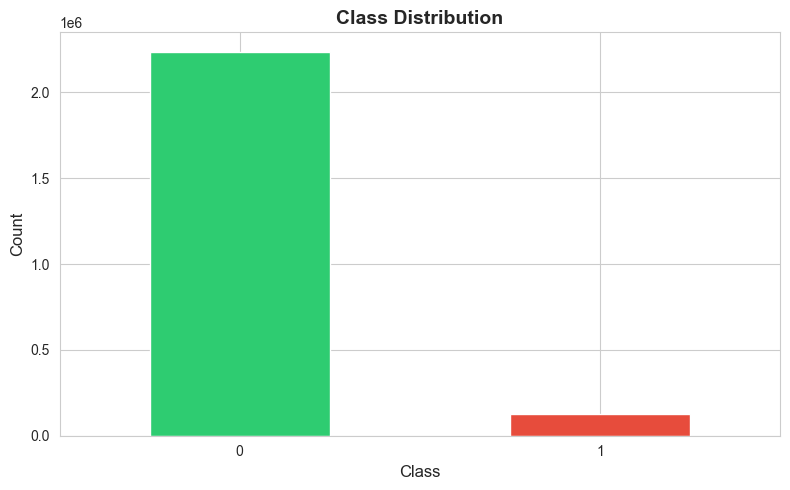

In [4]:
def load_and_explore_data(file_path):
    """Load dataset and perform initial exploration."""
    print("=" * 80)
    print("LOADING DATASET")
    print("=" * 80)
    
    try:
        df = pd.read_csv(file_path)
        print(f"✓ Dataset loaded successfully: {df.shape[0]} rows, {df.shape[1]} columns\n")
        
        print("Dataset Info:")
        print("-" * 80)
        print(df.info())
        
        print("\nFirst 5 Rows:")
        print("-" * 80)
        display(df.head())
        
        print("\nMissing Values:")
        print("-" * 80)
        missing = df.isnull().sum()
        missing = missing[missing > 0]
        if len(missing) > 0:
            print(missing)
        else:
            print("No missing values found")
        
        print("\nClass Distribution:")
        print("-" * 80)
        class_dist = df[CONFIG['target_column']].value_counts()
        print(class_dist)
        
        # Visualize class distribution
        plt.figure(figsize=(8, 5))
        class_dist.plot(kind='bar', color=['#2ecc71', '#e74c3c'])
        plt.title('Class Distribution', fontsize=14, fontweight='bold')
        plt.xlabel('Class', fontsize=12)
        plt.ylabel('Count', fontsize=12)
        plt.xticks(rotation=0)
        plt.tight_layout()
        plt.show()
        
        return df
    
    except FileNotFoundError:
        print(f"✗ Error: File '{file_path}' not found!")
        raise
    except Exception as e:
        print(f"✗ Error loading dataset: {e}")
        raise

# Load the dataset
df = load_and_explore_data(CONFIG['dataset_path'])


In [5]:
def preprocess_data(df):
    """Preprocess the dataset: handle missing values, encode categorical features, scale numeric features."""
    print("=" * 80)
    print("PREPROCESSING DATA")
    print("=" * 80)
    
    df = df.copy()
    
    # Handle missing values
    print("\n1. Handling missing values...")
    if df.isnull().sum().sum() > 0:
        # Fill numeric columns with median
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())
        
        # Fill categorical columns with mode
        categorical_cols = df.select_dtypes(include=['object']).columns
        categorical_cols = [col for col in categorical_cols if col != CONFIG['target_column']]
        for col in categorical_cols:
            df[col].fillna(df[col].mode()[0], inplace=True)
        print(f"   ✓ Missing values handled")
    else:
        print(f"   ✓ No missing values found")
    
    # Separate features and target
    X = df.drop(columns=[CONFIG['target_column']])
    y = df[CONFIG['target_column']]
    
    # Encode target variable
    print("\n2. Encoding target variable...")
    le_target = LabelEncoder()
    y_encoded = le_target.fit_transform(y)
    print(f"   ✓ Classes: {le_target.classes_}")
    print(f"   ✓ Encoding: {dict(zip(le_target.classes_, le_target.transform(le_target.classes_)))}")
    
    # Encode categorical features
    print("\n3. Encoding categorical features...")
    categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
    
    if categorical_cols:
        print(f"   Categorical columns found: {categorical_cols}")
        label_encoders = {}
        for col in categorical_cols:
            le = LabelEncoder()
            X[col] = le.fit_transform(X[col].astype(str))
            label_encoders[col] = le
        print(f"   ✓ {len(categorical_cols)} categorical features encoded")
    else:
        print(f"   ✓ No categorical features found")
        label_encoders = {}
    
    # Scale numeric features
    print("\n4. Scaling numeric features...")
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)
    print(f"   ✓ Features scaled using StandardScaler")
    
    print(f"\n✓ Preprocessing complete!")
    print(f"   Final feature shape: {X_scaled.shape}")
    print(f"   Class distribution: {dict(zip(*np.unique(y_encoded, return_counts=True)))}")
    
    return X_scaled, y_encoded, le_target, scaler, label_encoders

# Preprocess the data
X, y, le_target, scaler, label_encoders = preprocess_data(df)


PREPROCESSING DATA

1. Handling missing values...
   ✓ Missing values handled

2. Encoding target variable...
   ✓ Classes: [0 1]
   ✓ Encoding: {np.int64(0): np.int64(0), np.int64(1): np.int64(1)}

3. Encoding categorical features...
   Categorical columns found: ['IPV4_SRC_ADDR', 'IPV4_DST_ADDR', 'Attack']
   ✓ 3 categorical features encoded

4. Scaling numeric features...


ValueError: Input X contains infinity or a value too large for dtype('float64').